In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

In [42]:
# We can now change the start and end date of our data
# set as per our requirment

START_DATE = "2018-01-01" # @param {type: "date"}
END_DATE = "2022-01-12" # @param {type: "date"}

In [43]:
df = pd.read_csv('/content/daily_data.csv')
start_index = df[df.datetime == START_DATE].index[0]
end_index = df[df.datetime == END_DATE].index[0]
df = df.loc[start_index:end_index+1]
df

,datetime,high,low,close,open,volume
0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076
1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340
2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601
3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561
4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333
...,...,...,...,...,...,...
1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870
1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660
1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360
1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280


# 1. MACD (Moving Average Convergence Divergence)

The 12- and 26-day exponential moving averages (EMAs) are often the most quoted and analyzed short-term averages.

The EMA works by placing weight on recent data points. The EMA functions by producing buy and sells signals based on the crossovers and divergences it plots against the historical average. Traders and investors can use the EMA for short, specific time periods, as it can  reflect even small price fluctuations.

**MACD Line = EMA12 - EMA26**

**Signal Line = EMA9**

For buying or selling we consider a period of 3 days till the cross over has happended, to keep a buying signal.

In [44]:
lookback_period_long = 26
lookback_period_short = 12
avg_period = 9

**MACD** *(Slow Signal Line)* = **EMA12(p)** (12 Period EMA of price, fast) - **EMA26(p**) (26 Period EMA of price, slow)

**Signal Line MACD** *(Fast Signal Line)* = **EMA9(MACD)** (9 Period EMA of MACD)

In [45]:
# Method 2 - Using Pandas Functions
df['MACD'] = df.close.ewm(span = lookback_period_long, adjust = False).mean() - df.close.ewm(span = lookback_period_short, adjust = False).mean()
df['Signal_MACD'] = df.MACD.ewm(span = avg_period, adjust = False).mean()
df

,datetime,high,low,close,open,volume,MACD,Signal_MACD
0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076,0.000000,0.000000
1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340,-115.270655,-23.054131
2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601,-217.827657,-62.008836
3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561,-300.564708,-109.720011
4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333,-502.998982,-188.375805
...,...,...,...,...,...,...,...,...
1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870,2136.672368,1568.284564
1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660,2233.642180,1701.356087
1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360,2313.071268,1823.699123
1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280,2257.170852,1910.393469


# Trading using MACD
We will implement the crossover strategies.

**Signal-line crossover**
A "signal-line crossover" occurs when the MACD and average lines cross; that is, when the divergence (the bar graph) changes sign. The standard interpretation of such an event is a recommendation to buy if the MACD line crosses up through the average line (a "bullish" crossover), or to sell if it crosses down through the average line (a "bearish" crossover).These events are taken as indications that the trend in the stock is about to accelerate in the direction of the crossover.

We will generate a buying signal for 4 days after the MACD Line has crossed the Signal Line (and it still remains above it during those days), and similaly for the selling signal.

In [46]:
df['Buy_MACD'] = 0
n = 4

for i in range(len(df.index) - n):
  if(df.MACD[i] <= df.Signal_MACD[i] and df.MACD[i + 1] >= df.Signal_MACD[i+1]):  # Buy
    for j in range(1, n + 1):
      if(df.MACD[i + j] >= df.Signal_MACD[i + j]):
        df.Buy_MACD[i + j] = 1
      else:
        df.Buy_MACD[i + j] = 0
    i += n + 1

  elif(df.MACD[i] >= df.Signal_MACD[i] and df.MACD[i + 1] <= df.Signal_MACD[i+1]):  # Buy
    for j in range(1, n + 1):
      if(df.MACD[i + j] <= df.Signal_MACD[i + j]):
        df.Buy_MACD[i + j] = -1
      else:
        df.Buy_MACD[i + j] = 0
    i += n + 1

df

,datetime,high,low,close,open,volume,MACD,Signal_MACD,Buy_MACD
0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076,0.000000,0.000000,0
1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340,-115.270655,-23.054131,-1
2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601,-217.827657,-62.008836,-1
3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561,-300.564708,-109.720011,-1
4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333,-502.998982,-188.375805,-1
...,...,...,...,...,...,...,...,...,...
1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870,2136.672368,1568.284564,0
1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660,2233.642180,1701.356087,0
1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360,2313.071268,1823.699123,0
1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280,2257.170852,1910.393469,0


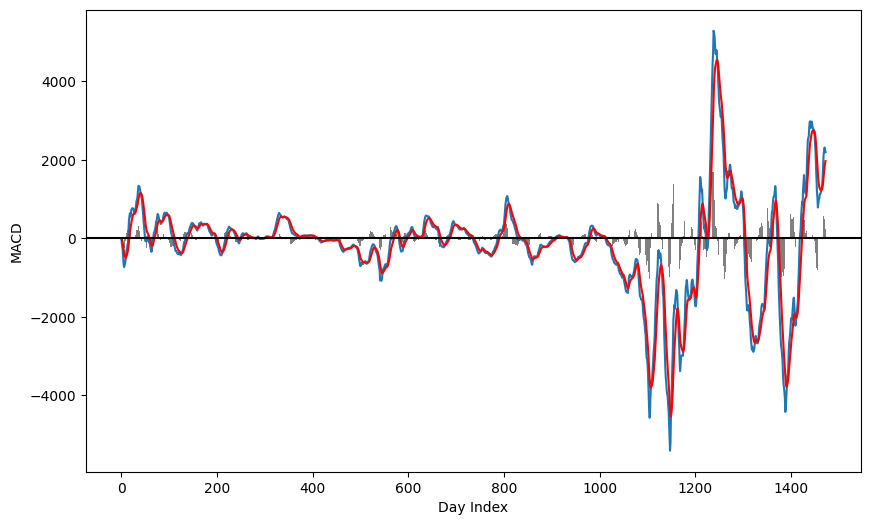

In [47]:
plt.figure(figsize = (10, 6))
plt.plot(df.MACD)
plt.plot(df.Signal_MACD, color = "Red")

plt.axhline(y = 0, color = "Black", linestyle='-')  # BaseLine
plt.bar(df.index, df.MACD - df.Signal_MACD, color="Grey", width = 0.6)
plt.xlabel("Day Index")
plt.ylabel("MACD")
plt.show()

# 2. Volume RSI

The Volume RSI (Relative Strength Index) is a volume indicator which is similar to the Relative Strength Index except that up-volume and down-volume are used in the formula of RSI instead of changes in price. Volume RSI oscillates around 50% centre-line in the range from 0 to 100%.

Volume RSI is a volume based technical indicator measuring speed and change of volume to the price down-side (down volume) and to the price up-side (up-volume). Volume RSI attempts to gauge price trend changes via changes in bullish (up volume) and bearish (down volume) pressure.

RSI = 100 – [100 ÷ ( 1 + (Average Gain During Up Periods ÷ Average Loss During Down Periods ))]

Average Gain = [(Past Average Gain) x 13 + Current Gain] ÷ 14

Average Loss = [(Past Average Loss) x 13 + Current Loss] ÷ 14

In [48]:
up_vol = []
down_vol = []
period = 14
RSI = []
for i in df.index:
  if(df.close[i] >= df.open[i]):
    up_vol.append(df.volume[i])
    down_vol.append(0)
  elif(df.close[i] < df.open[i]):
    up_vol.append(0)
    down_vol.append(df.volume[i])


df['Up_vol'] = pd.DataFrame(up_vol).ewm(span = period, adjust = False).mean()
df['Down_vol'] = pd.DataFrame(down_vol).ewm(span = period, adjust = False).mean()
df['VRSI'] = 100 - (100 / (1 + df.Up_vol / df.Down_vol))

# Trading using VRSI
We initiate a buy when the Volume RSI crosses the 50% mark from below and sell when it crosses the 50% mark from above.

The indsutry standards for overbought and oversold levels in Volume RSI are 70% and 30% respectively. However, on analyzing the graphs and tuning the values, 65% and 25% seems to fit best.

If the indicator's line goes above the 65% level, it signals that market is overbought and the trend may reverse downwards So we append a -2 to the stock, i.e,  and the stock will be sold irrespective of what the other indicators say, if no trade is currently going on.

Similarly, if the indicator's line goes below the level 25%, it signifies that market is oversold and the trend may reverse upwards. So we append a 2 to the stock, i.e,  and the stock will be sold irrespective of what the other indicators say, if no trade is currently going on. This is a sort of priority setting applicable in extreme cases only.

In [49]:
buy_signal = []

for i in range(len(df.index)):
  v = df.VRSI[i]
  if(v > 50 and v < 65):  # The stock is in an uptrend and should be bought
    buy_signal.append(1) # Stock is sold

  elif(v > 25 and v < 50):  # The stock is in a downtrend and should be sold
    buy_signal.append(1) # Stock is bought

  elif(v >= 65):  # The stock is overbrought and a reversal is expected
    buy_signal.append(-2) # Stock should be sold immediately

  elif(v <= 25):  # The stock is oversold and a reversal is expected
    buy_signal.append(2) # Stock should be bought immediately

df['Buy_VRSI'] = buy_signal

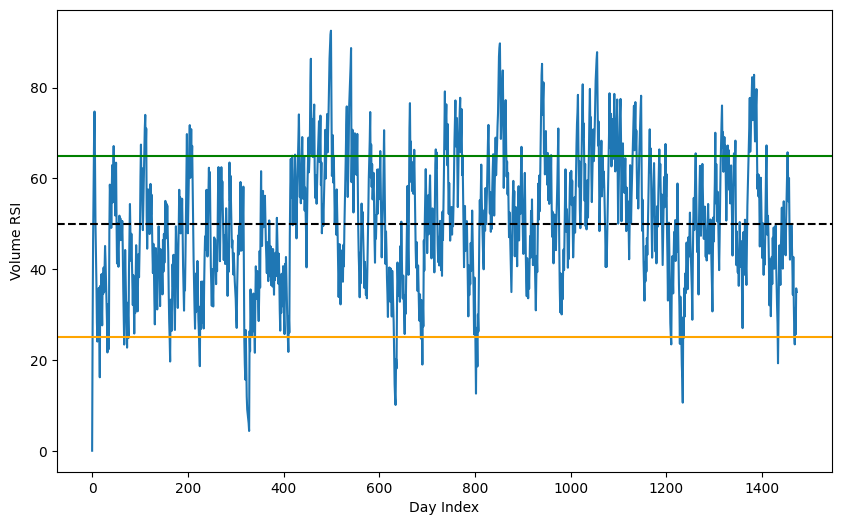

In [50]:
plt.figure(figsize = (10, 6))
plt.plot(df.VRSI)
plt.axhline(y = 50.0, color = "Black", linestyle='--')  # Signal Line
plt.axhline(y = 25.0, color = "Orange", linestyle='-') # Oversold Line
plt.axhline(y = 65.0, color = "Green", linestyle='-') # Overbought Line
plt.plot()
plt.xlabel("Day Index")
plt.ylabel("Volume RSI")
plt.show()

# 3. Average True Range

The average true range (ATR) is a price volatility indicator showing the average price variation of assets within a given time period. Investors can use the indicator to determine the best time for trading. The average true range also takes into account the gaps in the movement of price.

We will buy whenever the ATR goes above the SMA20 and sell when it drops below.



In [51]:
C1 = [df.high[0] - df.low[0]]
C2, C3 = [0], [0]
for i in range(1, len(df.index)):
  C1.append(df.high[i] - df.low[i])
  C2.append(abs(df.low[i] - df.close[i - 1]))
  C3.append(abs(df.low[i] - df.close[i - 1]))

true_range = []
for i in range(len(df.index)):
  true_range.append(max(C1[i], C2[i], C3[i]))

df['True_Range'] = true_range
period = 14
df['Avg_True_Range'] = df.True_Range.ewm(span = period, adjust = False).mean()
df['SMA20'] = df.Avg_True_Range.rolling(20).mean()

In [52]:
df['Buy_ATR'] = 0

for i in range(period, len(df.index)):
  if(df.Avg_True_Range[i] >= df.SMA20[i]):  # Buy
    df.Buy_ATR[i] = 1
  else: # Sell
    df.Buy_ATR[i] = -1

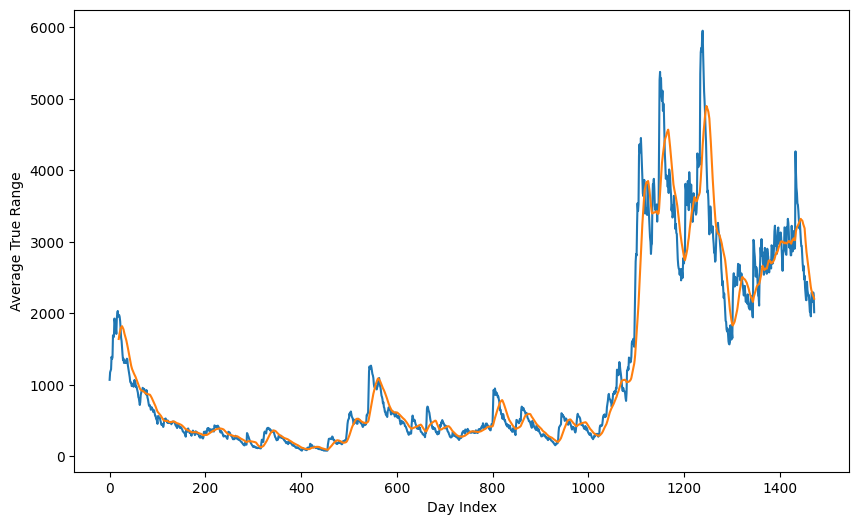

In [53]:
plt.figure(figsize = (10, 6))
plt.plot(df.Avg_True_Range)
plt.plot(df.SMA20)
plt.xlabel("Day Index")
plt.ylabel("Average True Range")
plt.show()

In [54]:
buy = pd.DataFrame({
    "Buy_MACD" : df.Buy_MACD,
    "Buy_VRSI" : df.Buy_VRSI,
    "Buy_ATR" : df.Buy_ATR
})

signal = []
for i in buy.index:
  if(buy.Buy_MACD [i]== 1 and buy.Buy_VRSI[i] == 1 and buy.Buy_ATR[i] == 1):   # Buy
    signal.append(1)
  elif(buy.Buy_MACD[i] == -1 and buy.Buy_VRSI[i] == -1 and buy.Buy_ATR[i] == -1):  # Sell
    signal.append(-1)
  elif((buy.Buy_MACD[i] == 2) | (buy.Buy_VRSI[i] == 2) | (buy.Buy_ATR[i] == 2)):  # Immediate buy
    signal.append(1)
  elif((buy.Buy_MACD[i] == -2) | (buy.Buy_VRSI[i] == -2) | (buy.Buy_ATR[i] == -2)):  # Immediate sell
    signal.append(-1)
  else:
    signal.append(0)

buy['Signal'] = signal

# Implementing Trading

We have an initial Capital value and we will trade using it. Trades can be Purchases or Short Selling.
For every purchase we will use only a certain % of our capital. We calculate the quantity we can purchase with that amount at that particular closing price, and add it to the quantity.

Once a trade has been initiated, another trade will not take place until the Stop Loss or Take Profit for that trade has been hit. Hence, only one trade can take place at a time and untill it is running, another trade won't be taken up according to the signals generated by the Technical Indicator of your choice.

In [55]:
capital = 10000000  # Stores the capital we have for the stock
P = 10000000 # Copy of Capital
portion = 0.8# Portion of the capital to be used for a purchase
quantity = 0    # Quantity which is bought
index = 0 # Stores the index of the last purchase
sl = 0.05  # Stop Loss
tp = 0.05  # Take Profit
trade = []  # Stores the indexes of all trades completed
Qty = []  # Stores all quanities
Profit = [] # Stores all profits
Loss = [] # Stores all loses
portfolio = [capital]

for i in range(len(df.index) - 1):

  if quantity == 0:   # Nothing has been purchased till now

    if(buy.Signal[i] == 1):   # We get a buying signal
      quantity = (capital * portion) // df.close[i]
      Qty.append(quantity)
      Stop_Loss = quantity * df.close[i] * (1 - sl)
      Take_Profit = quantity * df.close[i] * (1 + tp)
      index = i
      # print("Case 1: ", quantity, Stop_Loss, Take_Profit, capital, index)

    elif(buy.Signal[i] == -1): # We get a selling signal (Short Selling)
      quantity = (capital * portion) // df.close[i]
      Qty.append(quantity)
      Stop_Loss = quantity * df.close[i] * (1 - sl)
      Take_Profit = quantity * df.close[i] * (1 + tp)
      index = i
      # print("Case 2: ", quantity, Stop_Loss, Take_Profit, capital, index)

  elif quantity != 0:   # Selling Case

    if(df.close[i]*quantity >= Take_Profit):   # Securing the profits (For Long sell)
      p = ((df.close[i] - df.close[index]) * quantity)
      trade.append(i) # Trade is complete
      Profit.append(p)  # Appending the profit
      capital += p
      portfolio.append(capital)
      index = 0
      quantity = 0

    elif(df.close[i]*quantity <= Stop_Loss):   # Minimizing the Loss (For short sell)
      l = ((df.close[index] - df.close[i]) * quantity)
      capital -= l
      trade.append(i)   # Trade is complete
      Loss.append(l)  # Appending the loss
      portfolio.append(capital)
      index = 0
      quantity = 0

# Displaying the final results:-

In [56]:
print("Final Portfolio Value: ", capital)
print("Initial Portfolio Value: ", P)
print("Gross Profit: ", sum(Profit))
print("Gross Loss: ", -sum(Loss))
net = (capital - P)
print("Net Income: ", net)
if net > 0:
  print("Profit: ", net/P * 100, " %")
else:
  print("Loss: ", net/P * 100, " %")

print("Total Trades: ", len(trade))
print("Total Winning Trades: ", len(Profit))
print("Total Losing Trades: ", len(Loss))
print("Average Winning Trade: ",sum(Profit)/len(Profit))
print("Average Losing Trade: ",sum(Loss)/len(Loss))
print("Largest Losing Trade: ",min(Loss))
print("Largest winning trade: ",max(Profit))
total_trades = Profit + Loss

Final Portfolio Value:  78970861.33000006
Initial Portfolio Value:  10000000
Gross Profit:  235596516.32000002
Gross Loss:  -166625654.99
Net Income:  68970861.33000006
Profit:  689.7086133000006  %
Total Trades:  123
Total Winning Trades:  79
Total Losing Trades:  44
Average Winning Trade:  2982234.3837974686
Average Losing Trade:  3786946.704318182
Largest Losing Trade:  722044.8000000012
Largest winning trade:  9927190.650000008


In [57]:
sharpe = math.sqrt(252)*((np.mean(total_trades)-4.23)/np.std(total_trades))
sharpe

21.455102096415818

In [58]:
sortino = math.sqrt(252)*((np.mean(total_trades) - 4.23) / np.std(Loss))
sortino

18.15673003737906

# Plotting the Graph of Portfolio vs Time

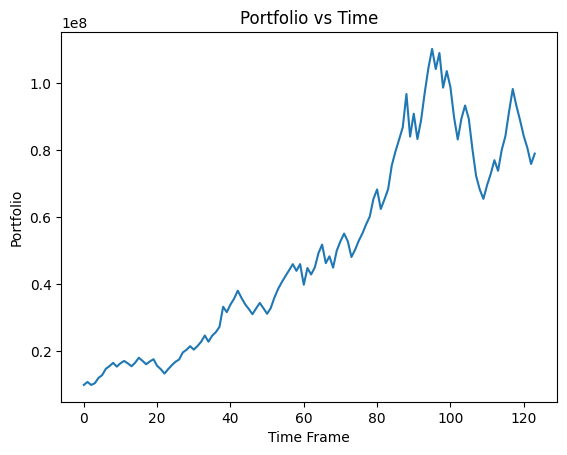

In [59]:
plt.plot(portfolio)
plt.xlabel("Time Frame")
plt.ylabel("Portfolio")
plt.title("Portfolio vs Time")
plt.show()